In [41]:
import argparse
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
from datetime import datetime
from matplotlib.backends.backend_pdf import PdfPages
import xbpch
from glob import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from dask.diagnostics import ProgressBar

In [42]:

OLD = '/home/brittany/Documents/HG/pythonHgBenchmark/trac_avg.geosfp_2x25_Hg.v12-01.bpch'
NEW = '/home/brittany/Documents/HG/pythonHgBenchmark/trac_avg.geosfp_2x25_Hg.v12-01.new.bpch'

In [45]:
OLD_ds = xbpch.open_bpchdataset(OLD)
NEW_ds = xbpch.open_bpchdataset(NEW)

/home/brittany/anaconda3/lib/python3.7/site-packages/pandas/io/parsers.py:710: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)


In [44]:
print (OLD_ds)

<xarray.Dataset>
Dimensions:            (lat: 91, lev: 47, lev_edge: 48, lon: 144, nv: 2, time: 12)
Dimensions without coordinates: lat, lev, lev_edge, lon, nv, time
Data variables:
    HG_SRCE_Hg0_an     (time, lon, lat) float32 dask.array<shape=(12, 144, 91), chunksize=(1, 144, 91)>
    time_bnds          (time, nv) datetime64[ns] 2013-01-01 ... 2014-01-01
    HG_SRCE_Hg0_aq     (time, lon, lat) float32 dask.array<shape=(12, 144, 91), chunksize=(1, 144, 91)>
    HG_SRCE_Hg0_oc     (time, lon, lat) float32 dask.array<shape=(12, 144, 91), chunksize=(1, 144, 91)>
    HG_SRCE_Hg0_ln     (time, lon, lat) float32 dask.array<shape=(12, 144, 91), chunksize=(1, 144, 91)>
    HG_SRCE_Hg0_na     (time, lon, lat) float32 dask.array<shape=(12, 144, 91), chunksize=(1, 144, 91)>
    HG_SRCE_Hg2_an     (time, lon, lat) float32 dask.array<shape=(12, 144, 91), chunksize=(1, 144, 91)>
    HG_SRCE_Hg2_aq     (time, lon, lat) float32 dask.array<shape=(12, 144, 91), chunksize=(1, 144, 91)>
    HG_SRCE_Hg2

In [46]:
print (NEW_ds)

<xarray.Dataset>
Dimensions:            (lat: 91, lev: 47, lev_edge: 48, lon: 144, nv: 2, time: 12)
Dimensions without coordinates: lat, lev, lev_edge, lon, nv, time
Data variables:
    HG_SRCE_Hg0_an     (time, lon, lat) float32 dask.array<shape=(12, 144, 91), chunksize=(1, 144, 91)>
    time_bnds          (time, nv) datetime64[ns] 2013-01-01 ... 2014-01-01
    HG_SRCE_Hg0_aq     (time, lon, lat) float32 dask.array<shape=(12, 144, 91), chunksize=(1, 144, 91)>
    HG_SRCE_Hg0_oc     (time, lon, lat) float32 dask.array<shape=(12, 144, 91), chunksize=(1, 144, 91)>
    HG_SRCE_Hg0_ln     (time, lon, lat) float32 dask.array<shape=(12, 144, 91), chunksize=(1, 144, 91)>
    HG_SRCE_Hg0_na     (time, lon, lat) float32 dask.array<shape=(12, 144, 91), chunksize=(1, 144, 91)>
    HG_SRCE_Hg2_an     (time, lon, lat) float32 dask.array<shape=(12, 144, 91), chunksize=(1, 144, 91)>
    HG_SRCE_Hg2_aq     (time, lon, lat) float32 dask.array<shape=(12, 144, 91), chunksize=(1, 144, 91)>
    HG_SRCE_Hg2

In [113]:
# Setting variables for the old model dataset
#OLD_Hg0 = xbpch.open_bpchdataset(
#    OLD, categories=['IJ_AVG_S_Hg0', ]
#)

OLD_Hg0 = xbpch.open_bpchdataset(OLD, fields=['Hg0', ], categories=['IJ_AVG_S']) 
OLD_Hg0 = OLD_ds['IJ_AVG_S_Hg0']

#OLD_Hg0_mean= OLD_Hg0.isel(lev=0).IJ_AVG_S_Hg0.mean('time')
                             
OLD_Hg2 = xbpch.open_bpchdataset(OLD, fields=['Hg2', ])
OLD_Hg2 = OLD_ds['IJ_AVG_S_Hg2']
TGM_Old = (OLD_Hg0 + OLD_Hg2)

#ds_seas = ds.groupby("time.season").mean('time')
#In [3]: met_data = xbpch.open_bpchdataset(
#   ...:     "my_data.bpch", categories=["DAO-FLDS", ]
#   ...: )
#   ...: 





# Setting variables for the new model data set
#NEW_Hg0 = xbpch.open_bpchdataset(NEW, fields=['IJ_AVG_S_Hg0', ])

                             
#NEW_Hg2 = xbpch.open_bpchdataset(NEW_ds, fields=['IJ_AVG_S_Hg2', ])

#TGM_New = NEW_Hg0 + NEW_Hg2

#print (OLD_Hg2)
#print (NEW_Hg0)
print (TGM_Old)

/home/brittany/anaconda3/lib/python3.7/site-packages/pandas/io/parsers.py:710: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)


<xarray.DataArray (time: 12, lon: 144, lat: 91, lev: 47)>
dask.array<shape=(12, 144, 91, 47), dtype=float32, chunksize=(1, 144, 91, 47)>
Dimensions without coordinates: time, lon, lat, lev


In [98]:
Abs_diff = TGM_New - TGM_Old
Perc_diff = (Abs_diff / TGM_Old)*100
print (Abs_diff)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*


[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143]


TypeError: unhashable type: 'numpy.ndarray'

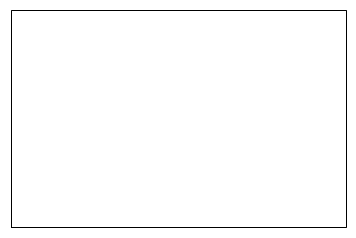

In [127]:
fig = plt.figure()

ax = fig.add_subplot(111, projection=ccrs.PlateCarree(), aspect='auto')


da = OLD_Hg0.isel(lev=0, time=0)
print(da.lon.values)

im = da.plot.contourf(x=da.lon.values, y=da.lat.values)#, transform=ccrs.PlateCarree())#, da.values.T)
#im = ax.contourf(da.lon.values, da.lat.values, da.values.T)
Icb = fig.colorbar(im, ax=ax, orientation='horizontal')

ax.add_feature(cfeature.COASTLINE)

ax.add_feature(cfeature.BORDERS)


AttributeError: 'Dataset' object has no attribute 'I'

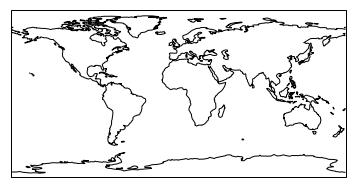

In [68]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
da=TGM_Old

im = ax.contourf(da.lon.values, da.lon.values, da.values.)

cb = fig.colorbar(im, ax=ax, orientation='horizontal')

ax.add_feature(cfeature.COASTLINE)

ax.add_feature(cfeature.BORDERS)